# XGBoost Classifier with Spark

In [1]:
import os
os.environ["OBJC_DISABLE_INITIALIZE_FORK_SAFETY"] = "YES"

In [2]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from xgboost.spark import SparkXGBClassifier
from pyspark import SparkConf, SparkContext

# SparkConfを作成し、メモリ設定を行う
conf = SparkConf() \
    .setAppName("MyApp") \
    .set("spark.driver.memory", "8g") \
    .set("spark.executor.memory", "8g")

# SparkContextを作成
sc = SparkContext(conf=conf)
spark = SparkSession(sc)

# データのロード
iris = datasets.load_iris()
X = iris.data
y = iris.target

# データをトレーニングとテストに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

feature_names = ["sepal_length", "sepal_width", "petal_length", "petal_width"]

# トレーニングデータをSpark DataFrameに変換
train_data = [(float(y_train[i]), float(X_train[i][0]), float(X_train[i][1]), float(X_train[i][2]), float(X_train[i][3])) for i in range(len(y_train))]
train_df = spark.createDataFrame(train_data, ["label", ] + feature_names)

# テストデータをSpark DataFrameに変換
test_data = [(float(y_test[i]), float(X_test[i][0]), float(X_test[i][1]), float(X_test[i][2]), float(X_test[i][3])) for i in range(len(y_test))]
test_df = spark.createDataFrame(test_data, ["label", ] + feature_names)

# 特徴量のアセンブル
assembler = VectorAssembler(inputCols=feature_names, outputCol="features")
train_df_assembled = assembler.transform(train_df).select("features", "label")
test_df_assembled = assembler.transform(test_df).select("features", "label")

# XGBoost クラスifierのトレーニング
classifier = SparkXGBClassifier(features_col='features', label_col='label')
model = classifier.fit(train_df_assembled)

# テストデータに対して予測
predict_df = model.transform(test_df_assembled)
predict_df.show(5)

24/07/14 06:31:41 WARN Utils: Your hostname, thamaMBP.local resolves to a loopback address: 127.0.0.1; using 172.20.10.2 instead (on interface en0)
24/07/14 06:31:41 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/07/14 06:31:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
2024-07-14 06:31:49,548 INFO XGBoost-PySpark: _fit Running xgboost-2.1.0 on 1 workers with
	booster params: {'objective': 'multi:softprob', 'device': 'cpu', 'num_class': 3, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2024-07-14 06:31:52,601 INFO XGBoost-PySpark: _train_booster Training on CPUs 1]
[06:31:53] Task 0 got rank 0
2024-07-14 06:31:54,740 INFO XGBoost-PySpark: _fit Finished xgboost trai

+-----------------+-----+--------------------+----------+--------------------+
|         features|label|       rawPrediction|prediction|         probability|
+-----------------+-----+--------------------+----------+--------------------+
|[6.1,2.8,4.7,1.2]|  1.0|[-2.5190052986145...|       1.0|[0.00311770546250...|
|[5.7,3.8,1.7,0.3]|  0.0|[3.03028845787048...|       0.0|[0.99022030830383...|
|[7.7,2.6,6.9,2.3]|  2.0|[-2.6479260921478...|       2.0|[4.56182082416489...|
|[6.0,2.9,4.5,1.5]|  1.0|[-2.6479260921478...|       1.0|[0.00217239256016...|
|[6.8,2.8,4.8,1.4]|  1.0|[-2.6479260921478...|       1.0|[0.00301787396892...|
+-----------------+-----+--------------------+----------+--------------------+
only showing top 5 rows



# SHAP

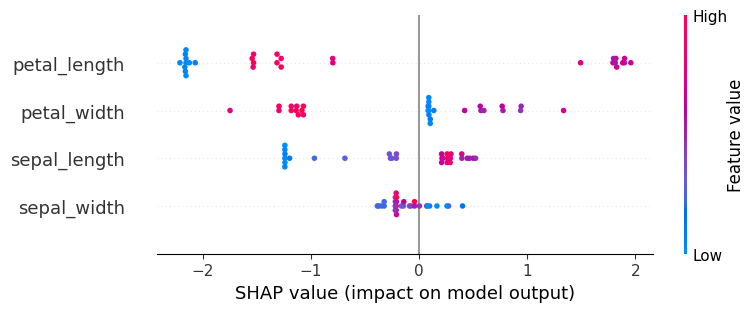

In [3]:
import shap

explainer = shap.Explainer(model.get_booster())
shap_values = explainer(test_df.toPandas()[feature_names])

shap.plots.beeswarm(shap_values[:,:,1])

# SHAP with Spark (not working)

In [8]:
# https://www.databricks.com/blog/2022/02/02/scaling-shap-calculations-with-pyspark-and-pandas-udf.html

from typing import Iterator
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType
import numpy as np
import pandas as pd


def calculate_shap(iterator: Iterator[pd.DataFrame]) -> Iterator[pd.DataFrame]:
    for X in iterator:
        print(X.shape)
        yield pd.DataFrame(
            explainer.shap_values(np.array(X), check_additivity=False)[0],
            columns=diabetes.feature_names,
        )

return_schema = StructType()
for feature in feature_names:
    return_schema = return_schema.add(StructField(feature, FloatType()))

shap_values = test_df_assembled.select("features").mapInPandas(calculate_shap, schema=return_schema)

shap_values.show() # => TypeError: float() argument must be a string or a real number, not 'dict'

# # https://github.com/shap/shap/issues/1460
# shap_obj = explainer(shap_values.toPandas())
# shap.plots.beeswarm(shap_obj)

# # https://stackoverflow.com/questions/77800583/converting-xgboost-shapely-values-to-shaps-explanation-object
# exp = shap.Explanation(shap_values.toPandas(), data=test_data, feature_names=diabetes.feature_names)
# shap.summary_plot(exp)

(3, 1) 9:>                                                          (0 + 1) / 1]
24/07/14 06:33:37 ERROR Executor: Exception in task 0.0 in stage 9.0 (TID 29)
org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/var/folders/w_/hg905l611296df772h1275kr0000gn/T/ipykernel_32338/548167221.py", line 13, in calculate_shap
  File "/Users/thama/ghq/github.com/mathmathpp2/synapselightgbm_trial/synapse-test/.venv/lib/python3.11/site-packages/shap/explainers/_tree.py", line 431, in shap_values
    X = xgboost.DMatrix(X, **dmatrix_props)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/thama/ghq/github.com/mathmathpp2/synapselightgbm_trial/synapse-test/.venv/lib/python3.11/site-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/thama/ghq/github.com/mathmathpp2/synapselightgbm_trial/synapse-test/.venv/lib/python3.11/site-packages/xgboost/core.py", line 878, in __init__
    handle, feature_n

PythonException: 
  An exception was thrown from the Python worker. Please see the stack trace below.
Traceback (most recent call last):
  File "/var/folders/w_/hg905l611296df772h1275kr0000gn/T/ipykernel_32338/548167221.py", line 13, in calculate_shap
  File "/Users/thama/ghq/github.com/mathmathpp2/synapselightgbm_trial/synapse-test/.venv/lib/python3.11/site-packages/shap/explainers/_tree.py", line 431, in shap_values
    X = xgboost.DMatrix(X, **dmatrix_props)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/thama/ghq/github.com/mathmathpp2/synapselightgbm_trial/synapse-test/.venv/lib/python3.11/site-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/thama/ghq/github.com/mathmathpp2/synapselightgbm_trial/synapse-test/.venv/lib/python3.11/site-packages/xgboost/core.py", line 878, in __init__
    handle, feature_names, feature_types = dispatch_data_backend(
                                           ^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/thama/ghq/github.com/mathmathpp2/synapselightgbm_trial/synapse-test/.venv/lib/python3.11/site-packages/xgboost/data.py", line 1203, in dispatch_data_backend
    return _from_numpy_array(
           ^^^^^^^^^^^^^^^^^^
  File "/Users/thama/ghq/github.com/mathmathpp2/synapselightgbm_trial/synapse-test/.venv/lib/python3.11/site-packages/xgboost/data.py", line 253, in _from_numpy_array
    data, _ = _ensure_np_dtype(data, data.dtype)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/thama/ghq/github.com/mathmathpp2/synapselightgbm_trial/synapse-test/.venv/lib/python3.11/site-packages/xgboost/data.py", line 224, in _ensure_np_dtype
    data = data.astype(dtype, copy=False)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: float() argument must be a string or a real number, not 'dict'
